In [1007]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (14.0, 8.0)

$$ d \sin{\theta} = m \lambda $$

$$ \frac{d y}{D} = m \lambda $$


In [1008]:
#get the raw data
import pandas as pd
data = pd.read_csv('./data/ex_inv_data.csv', skiprows = 3, dtype = 'float')

#clean the data up a bit:

#Round the slit width to even multiples of 25 um
data.insert(2, "original d", data.d)
data.d = np.round(data.d / 25e-6) * 25e-6

#correct for the vertical angle
data.insert(8, "D", np.sqrt(data.D_h **2 + data.D_v **2))

#convert y and delta_y to meters and divide it by n-1
data.y = data.y * 1e-3 / (data.n - 1)
data.delta_y = data.delta_y * 1e-3 / (data.n - 1)

data

,d_b,d_t,original d,d,delta_d,y,delta_y,n,D,D_h,D_v,delta_D_h
0,0.4974,0.4960,0.000497,0.000500,7.000000e-07,0.006500,0.000036,29,5.162857,5.16277,0.03,0.005
1,0.1954,0.1971,0.000196,0.000200,8.500000e-07,0.016200,0.000200,11,5.162857,5.16277,0.03,0.005
2,0.1015,0.0988,0.000100,0.000100,1.350000e-06,0.032167,0.000500,7,5.162857,5.16277,0.03,0.005
3,0.0509,0.0484,0.000050,0.000050,1.250000e-06,0.064500,0.002500,3,5.162857,5.16277,0.03,0.005
4,0.4974,0.4960,0.000497,0.000500,7.000000e-07,0.005882,0.000029,35,4.662867,4.66277,0.03,0.005
5,0.1954,0.1971,0.000196,0.000200,8.500000e-07,0.014667,0.000167,13,4.662867,4.66277,0.03,0.005
6,0.1015,0.0988,0.000100,0.000100,1.350000e-06,0.029167,0.000667,7,4.662867,4.66277,0.03,0.005
7,0.0509,0.0484,0.000050,0.000050,1.250000e-06,0.058000,0.002500,3,4.662867,4.66277,0.03,0.005
8,0.0234,0.0256,0.000024,0.000025,1.100000e-06,0.122000,0.017000,2,4.662867,4.66277,0.03,0.005
9,0.4974,0.4960,0.000497,0.000500,7.000000e-07,0.006176,0.000059,35,4.912862,4.91277,0.03,0.005


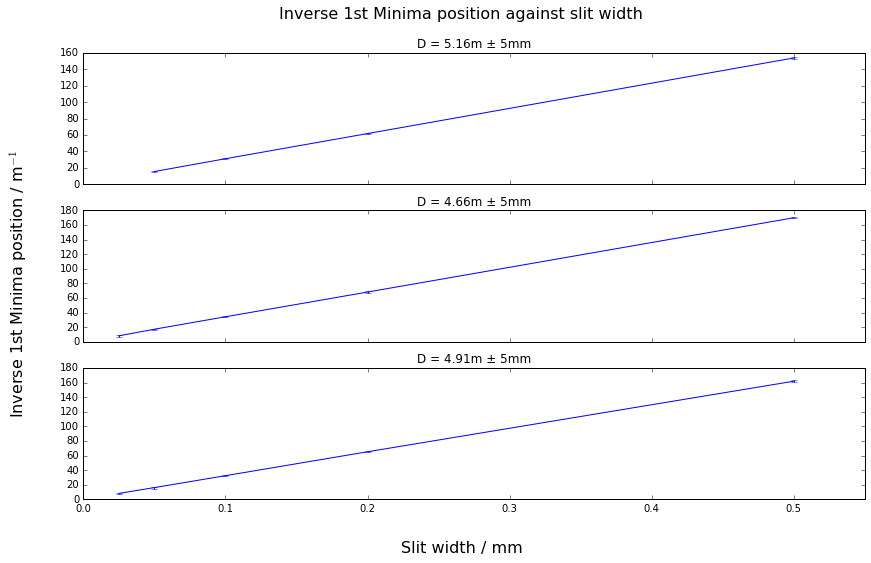

In [1009]:
f, axes = plt.subplots(3, sharex='col')

# Set common labels
f.text(0.5, 0.04, 'Slit width / mm', ha='center', va='center', fontsize = 16)
f.text(0.06, 0.5, 'Inverse 1st Minima position / m$^{-1}$', ha='center', va='center', rotation='vertical', fontsize = 16)

f.suptitle("Inverse 1st Minima position against slit width", fontsize=16)

#loop over three subsets of the data and plot
for ex, ax in zip((data[0:4], data[4:9], data[9:]), axes):
    ax.set_xlim(0, 0.55)
    
    #plotting inverse y
    inv_y = 1 / ex.y
    d_inv_y = ex.delta_y  / ex.y**2
    
    ax.errorbar(1e3 * ex["d"], inv_y, yerr = d_inv_y.as_matrix())
    ax.set_title("D = {:.3}m ± 5mm".format(ex.iloc[ 0,  9]))

#plt.savefig("./figs/Minima postions.png")

In [1010]:
#get the raw data from day 2 when we flipped the aperture
import pandas as pd
data2 = pd.read_csv('./data/data_day_2.csv', skiprows = 3, dtype = 'float')

#clean the data up a bit:

#Round the slit width to even multiples of 25 um
data2.insert(2, "original d", data2.d)
data2.d = np.round(data2.d / 25e-6) * 25e-6

#correct for the vertical angle
data2.insert(8, "D", np.sqrt(data2.D_h **2 + data2.D_v **2))

#convert y and delta_y to meters and divide it by n-1
data2.y = data2.y * 1e-3 / (data2.n - 1)
data2.delta_y = data2.delta_y * 1e-3 / (data2.n - 1)

#data from day 2, having flipped the aperture plate so that the other face is facing the laser
data2

,d_b,d_t,original d,d,delta_d,y,delta_y,n,D,D_h,D_v,delta_D_h
0,0.4974,0.4960,0.000497,0.00050,7.000000e-07,0.006575,0.000050,21,5.181287,5.1812,0.03,0.005
1,0.1954,0.1971,0.000196,0.00020,8.500000e-07,0.016143,0.000214,15,5.181287,5.1812,0.03,0.005
2,0.1015,0.0988,0.000100,0.00010,1.350000e-06,0.032833,0.000500,7,5.181287,5.1812,0.03,0.005
3,0.0509,0.0484,0.000050,0.00005,1.250000e-06,0.066000,0.002500,3,5.181287,5.1812,0.03,0.005
4,0.4974,0.4960,0.000497,0.00050,7.000000e-07,0.006714,0.000057,36,5.311285,5.3112,0.03,0.005
5,0.1954,0.1971,0.000196,0.00020,8.500000e-07,0.016846,0.000154,14,5.311285,5.3112,0.03,0.005
6,0.1015,0.0988,0.000100,0.00010,1.350000e-06,0.033667,0.000667,7,5.311285,5.3112,0.03,0.005
7,0.0509,0.0484,0.000050,0.00005,1.250000e-06,0.067000,0.002500,3,5.311285,5.3112,0.03,0.005
8,0.4974,0.4960,0.000497,0.00050,7.000000e-07,0.006250,0.000083,37,4.811294,4.8112,0.03,0.005
9,0.1954,0.1971,0.000196,0.00020,8.500000e-07,0.015167,0.000250,13,4.811294,4.8112,0.03,0.005


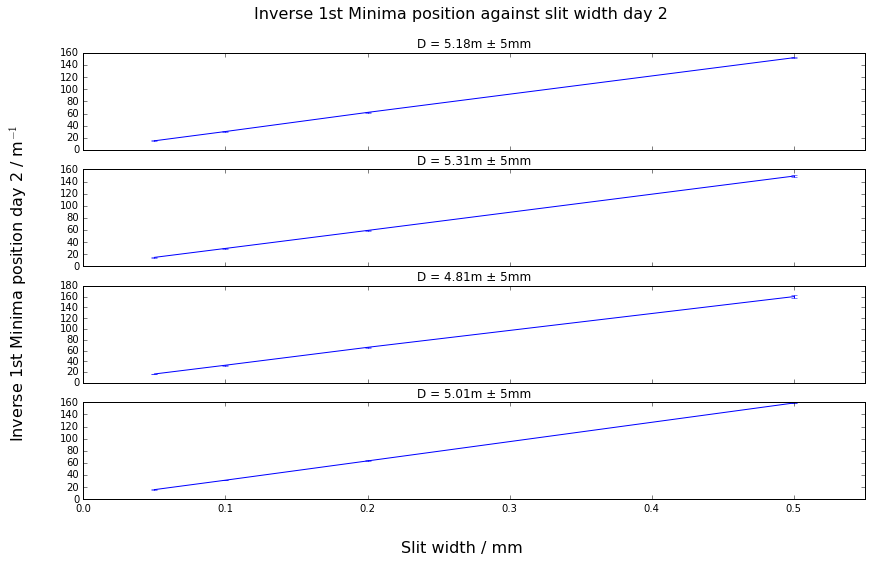

In [1020]:
f, axes = plt.subplots(4, sharex='col')

# Set common labels
f.text(0.5, 0.04, 'Slit width / mm', ha='center', va='center', fontsize = 16)
f.text(0.06, 0.5, 'Inverse 1st Minima position day 2 / m$^{-1}$', ha='center', va='center', rotation='vertical', fontsize = 16)

f.suptitle("Inverse 1st Minima position against slit width day 2", fontsize=16)

#loop over three subsets of the data and plot
for ex, ax in zip((data2[0:4], data2[4:8], data2[8:12], data2[12:]), axes):
    ax.set_xlim(0, 0.55)
    
    #plotting inverse y
    inv_y = 1 / ex.y
    d_inv_y = ex.delta_y  / ex.y**2
    
    ax.errorbar(1e3 * ex["d"], inv_y, yerr = d_inv_y.as_matrix())
    ax.set_title("D = {:.3}m ± 5mm".format(ex.iloc[ 0,  9]))

#plt.savefig("./figs/Minima postions.png")

We want to fit a function of the form:
$$ y = \lambda \frac{D}{d} $$

In [1021]:
true_l = 632.8e-9

#results from day 1
from scipy.optimize import curve_fit

def fn(x, l):
    D, d = x
    return l*D / d

def fit(D ,d ,y, delta_y, p0 = true_l):
    popt, pcov = curve_fit(fn, np.array([D, d]), y, p0 = p0, sigma = delta_y, absolute_sigma = True)
    l = popt[0]
    sigma = np.sqrt(pcov[0])[0]
    return l, sigma

l1, delta_l1 = fit(data.D, data.d, data.y, data.delta_y)
print("Our lambda from day 1 = {:.4}m ± {:.1}m".format(l1, delta_l1))


### results from the paper we found ###
g = 0.601 * 1e6 #m^-1
delta_g = 0.003 * 1e6 #m^-1
L = 2.653 #m
l3 = 1 / (g * L)
delta_l3 = delta_g / (L * g)**2

print("External lambda = {:.4}m ± {:.1}m".format(l3, delta_l3))

#results from day 2
l2, delta_l2 = fit(data2.D, data2.d, data2.y, data2.delta_y)
print("Our lambda from day 2 = {:.4}m ± {:.1}m".format(l2, delta_l2))

Our lambda from day 1 = 6.289e-07m ± 2e-09m
External lambda = 6.272e-07m ± 1e-09m
Our lambda from day 2 = 6.313e-07m ± 2e-09m


The above regression doesn't take into account the errors in D so I'll try adding gaussian noise N(mean = 0, sigma) to the D values and runnning the regression many times, to estimate the error in the regression due to error in D

In [1022]:
def trial():
    noise = np.random.normal(loc = 0.0, scale = 0.005, size = len(data.D))
    D = data.D + noise
    l, sigma = fit(D, data.d, data.y, data.delta_y)
    return l
ls = np.array([trial() for i in range(1000)])
print("sigma due to errors in D: ±{:.3}nm".format(ls.std() * 1e9))
print("sigma due to errors in y: ±{:.3}nm".format(delta_l1 * 1e9))

delta_l1 = np.sqrt(delta_l1**2 + ls.std()**2)
print("Total: ±{:.3}nm".format(delta_l1 * 1e9))

sigma due to errors in D: ±0.298nm
sigma due to errors in y: ±1.84nm
Total: ±1.87nm


Clearly the error in D makes very little difference

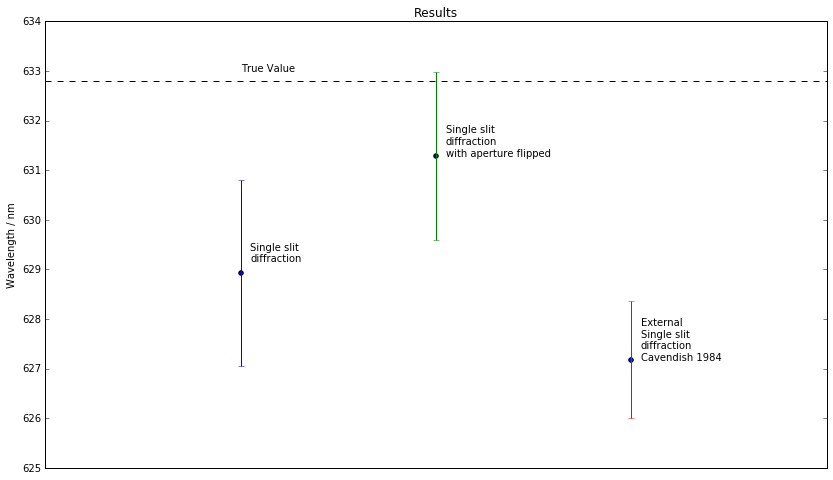

In [1023]:
#collect the results together with some labels
ls = np.array([l1, l2, l3]) * 1e9
delta_ls = np.array([delta_l1, delta_l2, delta_l3]) * 1e9
labels = ('Single slit\ndiffraction\n',
          'Single slit\ndiffraction\nwith aperture flipped',
          'External\nSingle slit\ndiffraction\nCavendish 1984')

for n, l, delta_l, label in zip(range(len(ls)), ls, delta_ls, labels):
    plt.scatter((n,), (l,))
    plt.errorbar((n,), (l,), yerr = (delta_l,))
    plt.annotate(label, (n + 0.05, l))

#true value
plt.plot((-1, len(ls)), (true_l * 1e9, true_l * 1e9), "k--")
plt.annotate("True Value", (0,true_l * 1e9 + 0.2))

plt.gca().get_xaxis().set_visible(False)
plt.title("Results")
plt.xlim((-1,len(ls)))
plt.gca().set_ylabel('Wavelength / nm')
plt.savefig("./figs/Results.png")

Now estimate the errors using deviation plots 

In [1015]:
minima = pd.read_csv('./data/minima_deviations.csv', skiprows = [0,], dtype = 'float')
x = np.arange(10, -11)
minima

,Pos,Tom,Lauren,William,Henry
0,10,65.5,65.0,65.5,66.0
1,9,59.5,59.5,59.5,59.0
2,8,52.5,52.5,52.0,52.0
3,7,46.5,46.0,46.0,45.5
4,6,39.5,40.0,39.0,39.0
5,5,33.0,33.5,33.0,33.0
6,4,26.0,26.5,26.0,25.0
7,3,20.0,20.0,19.5,20.0
8,2,13.5,14.0,13.0,13.0
9,1,7.0,6.0,6.5,7.0


Tom: d from curve fit: 	6.557mm
Tom: dist / n: 		6.55mm

Lauren: d from curve fit: 	6.558mm
Lauren: dist / n: 		6.55mm

William: d from curve fit: 	6.593mm
William: dist / n: 		6.575mm

Henry: d from curve fit: 	6.506mm
Henry: dist / n: 		6.55mm



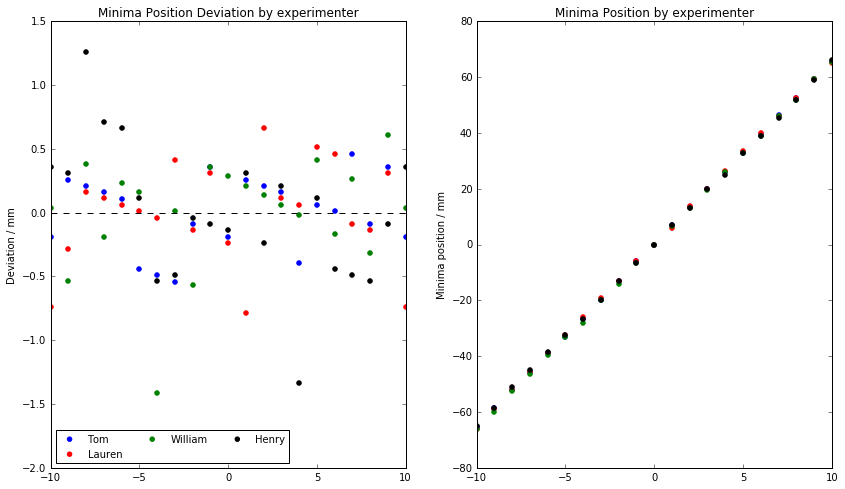

In [1016]:
names = [("Tom",'b'),("Lauren", "r"), ("William", 'g'), ("Henry", "k")]
lines = []
f, (ax1, ax2) = plt.subplots(1,2)

for name,col in names:
    #fit a straight line to each
    d,C = np.polyfit(minima.Pos, minima[name], deg = 1)
    print("{}: d from curve fit: \t{:.4}mm".format(name, d))

    ax2.scatter(minima.Pos,minima[name], color = col)
    d_est = (minima[name].iloc[0] - minima[name].iloc[-1]) / 20
    print("{}: dist / n: \t\t{:.4}mm\n".format(name,  d_est))
    
    #plot deviations from (max - min) / n
    lines.append( ax1.scatter(minima.Pos,minima[name] - (d_est*minima.Pos + C), color = col) )
    

ax1.legend(lines,
            [n for n,c in names],
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=10)

ax1.plot((-10, 10), (0, 0), "k--")
ax1.set_title("Minima Position Deviation by experimenter")
ax2.set_title("Minima Position by experimenter")
ax1.set_xlim((-10,10))
ax2.set_xlim((-10,10))
ax1.set_ylabel('Deviation / mm')
ax2.set_ylabel('Minima position / mm')
plt.savefig("./figs/Minima_deviations.png")    


In [1017]:
#read data about the slit widths done by each experimenter
sw = pd.read_csv('./data/Slit_Widths.csv', skiprows = [1,], dtype = 'float')
x = np.arange(1, 6)
sw

,Slit Number,Measured By Taki using transmitted light,Unnamed: 2,Measure By Tom using transmitted light,Unnamed: 4,Measure By Tom using reflected light,Unnamed: 6
0,1,0.4960,0.4974,0.5009,0.5003,0.5002,0.4991
1,2,0.1971,0.1954,0.2010,0.1991,0.1996,0.1990
2,3,0.0988,0.1015,0.1016,0.0976,0.0995,0.1001
3,4,0.0484,0.0509,0.0520,0.0510,0.0466,0.0497
4,5,0.0256,0.0234,0.0262,0.0250,0.0241,0.0259


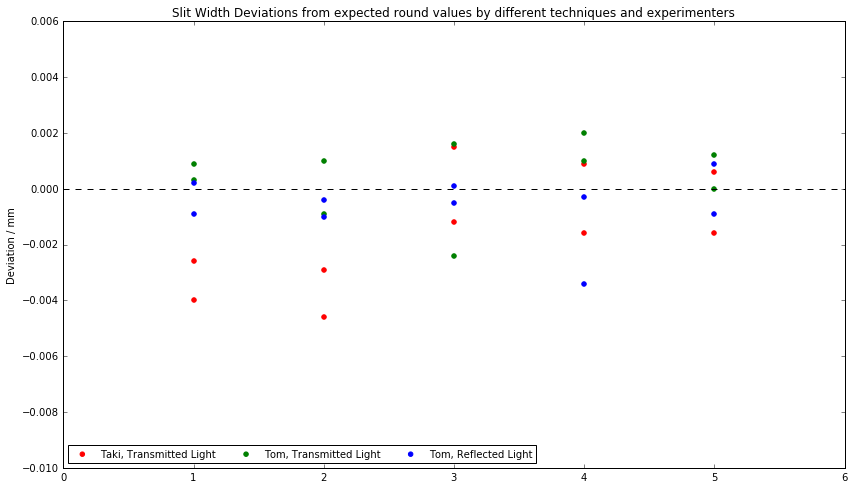

In [1018]:
#plot the deviations in slit width measurements
ys =[ np.array(sw[column_name]) - np.array(data.d[4:9]) * 1e3 for column_name in sw]

taki_t = plt.scatter(x, ys[1], marker='o', color = "r")
taki_b = plt.scatter(x, ys[2], marker='o', color = "r")

tom_t = plt.scatter(x, ys[3], marker='o', color = "g")
tom_b = plt.scatter(x, ys[4], marker='o', color = "g")

tom_t_r = plt.scatter(x, ys[5], marker='o', color = "b")
tom_b_r = plt.scatter(x, ys[6], marker='o', color = "b")

plt.legend((taki_t, tom_t, tom_t_r),
           ('Taki, Transmitted Light',
            'Tom, Transmitted Light',
            'Tom, Reflected Light'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=10)

#true value
plt.plot((0, 6), (0, 0), "k--")
plt.title("Slit Width Deviations from expected round values by different techniques and experimenters")
plt.xlim((0,6))
plt.gca().set_ylabel('Deviation / mm')
plt.savefig("./figs/Slit_deviations.png")